# Decision Trees


## In this notebook I will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

In [1]:
import numpy
from platform import python_version
print(numpy.version.version)
print(python_version())

1.20.1
3.8.8


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)    # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [3]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [4]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x2bdf32bb430>, <__main__.Node at 0x2bdf32bb790>]

## Data preprocessing

For the following exercise, I will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [5]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

In [6]:
data.head(5)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [7]:
#############################################################################
#     Find columns with missing values and remove them from the data.       #

num_null_values = data.isnull().sum().sum()
data = data.dropna(axis=1, how='any')
print("Number of missing values is : {}".format(num_null_values))

Number of missing values is : 0


We will split the dataset to `Training` and `Testing` datasets.

In [8]:
from sklearn.model_selection import train_test_split
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y]) 

# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation.

In [9]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
    Input:
    - data: any dataset where the last column holds the labels.
    Returns the gini impurity.    
    """
    gini = 0.0
    n_edible = (data[:,-1] == "e").sum()     # Number of "e" class in the currunt data
    n_poisonous = (data[:,-1] == "p").sum()  # Number of "p" class in the currunt data
    n_lables = data.shape[0]
    gini = 1-((n_edible/n_lables)**2+(n_poisonous/n_lables)**2)
    return gini

In [10]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.
    Input:
    - data: any dataset where the last column holds the labels.
    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    p_edible = (data[:,-1] == "e").sum()/data.shape[0]      # probability of "e" class in the currunt data
    p_poisonous = (data[:,-1] == "p").sum()/data.shape[0]   # probability of "e" class in the currunt data
    entropy += -(p_edible*np.log2(p_edible))-(p_poisonous*np.log2(p_poisonous))
    if (p_edible==1 or p_poisonous==1):
        return 0
    else:
        return entropy

In [11]:
##### Test #####
print("Gini : {}, Entropy : {}".format(calc_gini(X), calc_entropy(X)))

Gini : 0.4995636322379775, Entropy : 0.9993703627906085


## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). 

In [12]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.
    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.
    Returns the goodness of split (or the Gain Ration).  
    """
    goodness = 0
    impurity_before = impurity_func(data)   # impurity before splitting according to a given feature
    impurity_after = 0
    values = np.unique(data[:,feature])     # list of all unique values in feature
    split_info = 0
    S = data[:,feature].shape[0]            #Size of current data
    for v in values:
        S_v = data[(data[:,feature] == v)]  #subset group with common value
        weight = len(S_v)/S    
        impurity_after += (weight * impurity_func(S_v))
        split_info += -(weight * np.log2(weight))
    goodness = impurity_before-impurity_after
    ratio = goodness/split_info
    if (gain_ratio):
        return ratio 
    else:
        return goodness 

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [13]:
class DecisionNode(object):
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, data, feature, common_value):
        self.feature = feature            # column index of criteria by wich we will split
        if (feature==None):
            self.values = None
            self.leaf = True
        else:
            self.values = np.unique(data[:,feature]) #list of unique values of chosen feature
            self.leaf = False
        self.children = []                # list of all the children nodes
        self.common_value = common_value  # the value by which the node was splited from the parent node
        self.data = data 
        
    def add_child(self, node):
        self.children.append(node)  
    def pred (self):                      # calculating the major class in the data, and gives a prediction
        e = (self.data[:,-1] == "e").sum()
        p = (self.data[:,-1] == "p").sum()
        if(e>p):
            return "e"
        else:
            return "p"

In [14]:
def build_tree(data, impurity, value=None, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 
    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree
    Output: the root node of the tree.
    """
    root = None
    def best_feature (data,gain_ratio=False):  #finds best feature by wich to split, note feature is a column index
        feature_split = None
        current_goodness = 0
        best_goodness = np.NINF
        for i in range(len(data[0,:-1])):
            current_goodness = goodness_of_split(data, i, impurity, gain_ratio)
            if (current_goodness > best_goodness and len(np.unique(data[:,i]))>1 ):
                feature_split = i
                best_goodness = current_goodness
            elif (current_goodness==0):
                continue
        return feature_split
    
    if (max_depth>0 and len(data)>min_samples_split and impurity(data)!=0):
        feature_split = best_feature(data,gain_ratio)     # finding the best for splitting the data
        root = DecisionNode(data, feature_split, value)   # creating a new node with the best feature
        max_depth -= 1
        if(feature_split!=None):
            for v in root.values:                         #creating the children for the previous node:
                S_v = data[(data[:,feature_split] == v)]  # S_v is the splited data according to the parent's feature
                root.add_child(build_tree(S_v,impurity,v,gain_ratio,min_samples_split,max_depth))
        return root
    else:
        root = DecisionNode(data, None, value)            # the root is a leaf
        return root

In [15]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini)                                   # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy)                             # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`.

In [16]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
    Output: the prediction of the instance.
    """
    pred = None
    if (node.leaf):
        return node.pred()
    else:
        for child in node.children:
            if (child.common_value == instance[node.feature]):
                return predict(child, instance)
        return node.pred()
                

In [17]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    correct = 0 # number of successfull predictions
    for i in range(dataset.shape[0]):
        prediction = predict(node, dataset[i,:])
        if (prediction == dataset[i,-1]):
            correct += 1
    return correct / dataset.shape[0] 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [18]:
print("Gini tree accuracy \nTrain: {} ,Test: {}".format(calc_accuracy(tree_gini,X_train),calc_accuracy(tree_gini,X_test)))
print("----------------------------------")
print("Entropy tree accuracy \nTrain: {} ,Test: {}".format(calc_accuracy(tree_entropy,X_train),calc_accuracy(tree_entropy,X_test)))
print("----------------------------------")
print("Entropy gain ratio tree accuracy \nTrain: {} ,Test: {}".format(calc_accuracy(tree_entropy_gain_ratio,X_train),calc_accuracy(tree_entropy_gain_ratio,X_test)))

Gini tree accuracy 
Train: 1.0 ,Test: 0.7749876907927129
----------------------------------
Entropy tree accuracy 
Train: 1.0 ,Test: 0.7804037419990153
----------------------------------
Entropy gain ratio tree accuracy 
Train: 1.0 ,Test: 0.7902511078286558


## Depth pruning


Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

In [19]:
depth_trees = []
train_accuracy = []
test_accuracy = []
for i in range(1,9):
    depth_trees.append(build_tree(data=X_train, impurity=calc_entropy,gain_ratio=True, max_depth=i))
    train_accuracy.append(calc_accuracy(depth_trees[i-1],X_train))
    test_accuracy.append(calc_accuracy(depth_trees[i-1],X_test))

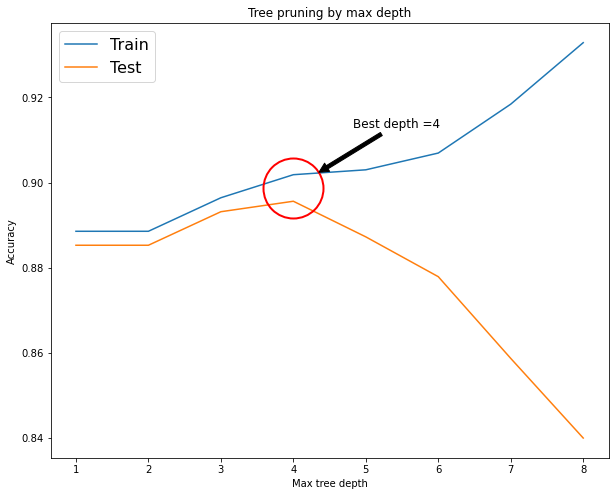

In [20]:
max_acc = test_accuracy.index(max(test_accuracy)) + 1
plt.plot(np.arange(8)+1, train_accuracy,label="Train")
plt.plot(np.arange(8)+1, test_accuracy,label="Test")    
plt.xlabel('Max tree depth')
plt.ylabel('Accuracy')
plt.title('Tree pruning by max depth')
plt.legend(fontsize="16")
plt.plot(max_acc, (train_accuracy[max_acc-1] + test_accuracy[max_acc-1]) / 2, 'o',ms=60, mec='red', mfc='none', mew=2)
plt.annotate('Best depth =' + str(max_acc), xy=(max_acc,(train_accuracy[max_acc-1] + test_accuracy[max_acc-1]) / 2), xytext=(60, 60),
   textcoords='offset points',
   color='black', size='large',
   arrowprops=dict(
      arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
      facecolor='black', shrinkB=30))
plt.show()

## Min Samples Split


Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

In [21]:
min_sample_trees = []
min_samples_split = [1,5,10,20,50]
train_accuracy = []
test_accuracy = []
indx=0
for i in min_samples_split:
    min_sample_trees.append(build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=i))
    train_accuracy.append(calc_accuracy(min_sample_trees[indx],X_train))
    test_accuracy.append(calc_accuracy(min_sample_trees[indx],X_test))
    indx+=1

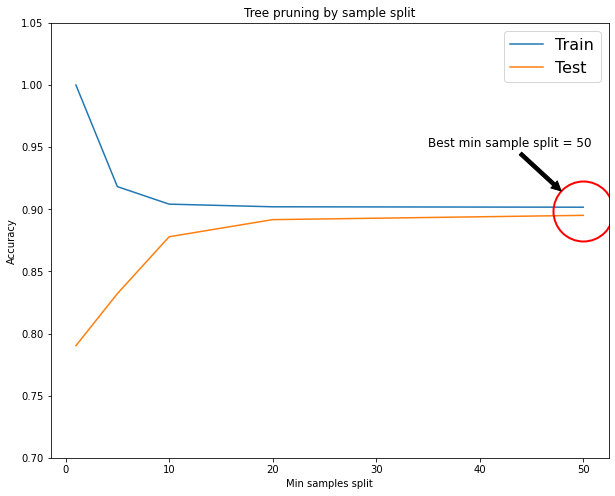

In [22]:
max_acc = test_accuracy.index(max(test_accuracy))

plt.ylim([0.7, 1.05])
plt.plot(min_samples_split, train_accuracy,label="Train")
plt.plot(min_samples_split, test_accuracy,label="Test")    
plt.xlabel('Min samples split')
plt.ylabel('Accuracy')
plt.title('Tree pruning by sample split')
plt.legend(fontsize="16")
plt.plot(min_samples_split[max_acc], (train_accuracy[max_acc] + test_accuracy[max_acc]) / 2, 'o',ms=60, mec='red', mfc='none', mew=2)
plt.annotate('Best min sample split = 50',(min_samples_split[max_acc], (train_accuracy[max_acc] + test_accuracy[max_acc]) / 2), xytext=(35,0.95),
   color='black', size='large',
   arrowprops=dict(
      arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
      facecolor='black', shrinkB=30))
plt.show()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [23]:
tree_max_depth = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=4)
tree_min_samples_split = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=50)

## Number of Nodes


Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [24]:
def count_nodes(node):
    """
    Count the number of node in a given tree
    Input:
    - node: a node in the decision tree.
    Output: the number of node in the tree.
    """
    if (node.leaf):
        return 1
    else:
        sum_children = 0
        for child in node.children:
            sum_children += count_nodes(child)
        return sum_children + 1
print("Number of nodes in max depth tree : {}".format(count_nodes(tree_max_depth)))
print("Number of nodes in min samples split tree: {}".format(count_nodes(tree_min_samples_split)))

Number of nodes in max depth tree : 205
Number of nodes in min samples split tree: 349


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

In [25]:
def print_tree(node, depth=0,  is_root = True, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above
    Input:
    - node: a node in the decision tree
    - is_root: a flag that signify whether the node is the root of the tree or not

    This function has no return value
    '''
    def count_lables(node):  # A function, which returns a dictionary of the number of edibles and poisonous instances in the node's data
        count_dict = {'e': 0, 'p': 0}
        edible = (node.data[:,-1] == "e").sum()
        poisonous = (node.data[:,-1] == "p").sum()
        count_dict['e'] = edible
        count_dict['p'] = poisonous
        return count_dict
    
    def print_leaf(node, parent_feature): # a function, which prints a leaf according to the desired format
        print("  " * depth + "[X" + str(parent_feature) + "=" + str(node.common_value) + ", Leaf]: " + str(count_lables(node)) + "]")
        return
    
    def print_node(node, parent_feature): # a function, which prints a node according to the desired format
        print("  " * depth + "[X" + str(parent_feature) + "=" + str(node.common_value) + ", feature= X" + str(node.feature) + "]")
        return
              
    def print_root(node): # a function, which prints a root according to the desired format
        print("  " * depth + "[Root, feature= X" + str(node.feature) + "])")
        return

    if is_root:
        print_root(node)
        is_root = False #there is only one root in a tree, thus all the next recursive calls will not consider thier nodes as root
        depth += 1 #
        for child in range(len(node.children)):
              print_tree(node.children[child], depth, is_root, parent_feature=node.feature)
    
    elif (node.leaf):
        print_leaf(node,parent_feature)
    
    else:
        print_node(node, parent_feature)
        depth += 1
        for child in range(len(node.children)):
              print_tree(node.children[child], depth, is_root, parent_feature=node.feature)
        

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [26]:
depths_testing = [1, 2, 3, 4]                   # depths higher yeild more than 50 nodes hence this is the relevant range to check
min_samples_testing = [350, 400, 450, 500, 550] # This was also found to be the relevant range to check

for depth in depths_testing:
    tree_limited_depth = build_tree(X_train, calc_gini, gain_ratio=False, min_samples_split=1, max_depth = depth)
    if count_nodes(tree_limited_depth) < 50:
        acc = calc_accuracy(tree_limited_depth, X_test)
        print("Tree with depth " + str(depth) + " and less than 50 nodes, has accuracy of: " + str(acc))

for samples in min_samples_testing:
    tree_limited_samples = build_tree(X_train, calc_gini, gain_ratio=False, min_samples_split=samples, max_depth = 1000)
    if count_nodes(tree_limited_samples) < 50:
        acc = calc_accuracy(tree_limited_samples, X_test)
        print("Tree with minimum sample spllit of " + str(samples) + " and less than 50 nodes, has accuracy of: " + str(acc))

Tree with depth 1 and less than 50 nodes, has accuracy of: 0.8852781880846874
Tree with depth 2 and less than 50 nodes, has accuracy of: 0.8931560807483998
Tree with minimum sample spllit of 450 and less than 50 nodes, has accuracy of: 0.8946331856228459
Tree with minimum sample spllit of 500 and less than 50 nodes, has accuracy of: 0.8931560807483998
Tree with minimum sample spllit of 550 and less than 50 nodes, has accuracy of: 0.8931560807483998


In [27]:
depths_testing = [1, 2, 3, 4, 6, 7]   #depths higher yeild more than 50 nodes hence this is the relevant range to check
min_samples_testing = [1,5,10,20,50]  #This was also found to be the relevant range to check

for depth in depths_testing:
    tree_limited_depth = build_tree(X_train, calc_gini, gain_ratio=False, min_samples_split=1, max_depth = depth)
    if count_nodes(tree_limited_depth) < 50:
        acc = calc_accuracy(tree_limited_depth, X_test)
        print("Tree with depth " + str(depth) + " and less than 50 nodes, has accuracy of: " + str(acc))

for samples in min_samples_testing:
    tree_limited_samples = build_tree(X_train, calc_gini, gain_ratio=False, min_samples_split=samples, max_depth = 1000)
    if count_nodes(tree_limited_samples) < 50:
        acc = calc_accuracy(tree_limited_samples, X_test)
        print("Tree with minimum sample spllit of " + str(samples) + " and less than 50 nodes, has accuracy of: " + str(acc))

Tree with depth 1 and less than 50 nodes, has accuracy of: 0.8852781880846874
Tree with depth 2 and less than 50 nodes, has accuracy of: 0.8931560807483998


*We found that the tree with the best accuracy and with less than 50 nodes is :* **Tree pruned with Max depth 2.**

In [28]:
best_tree = build_tree(X_train, calc_entropy, gain_ratio=True, max_depth = 2)
print_tree(best_tree)

[Root, feature= X4])
  [X4=a, feature= X2]
    [X2=n, Leaf]: {'e': 33, 'p': 5}]
    [X2=w, Leaf]: {'e': 107, 'p': 7}]
    [X2=y, Leaf]: {'e': 133, 'p': 19}]
  [X4=c, feature= X6]
    [X6=c, Leaf]: {'e': 7, 'p': 63}]
    [X6=w, Leaf]: {'e': 3, 'p': 74}]
  [X4=f, feature= X10]
    [X10=f, Leaf]: {'e': 14, 'p': 91}]
    [X10=k, Leaf]: {'e': 134, 'p': 1037}]
    [X10=s, Leaf]: {'e': 22, 'p': 310}]
  [X4=l, feature= X1]
    [X1=f, Leaf]: {'e': 19, 'p': 1}]
    [X1=s, Leaf]: {'e': 94, 'p': 16}]
    [X1=y, Leaf]: {'e': 159, 'p': 10}]
  [X4=m, feature= X0]
    [X0=f, Leaf]: {'e': 1, 'p': 8}]
    [X0=k, Leaf]: {'e': 1, 'p': 10}]
    [X0=x, Leaf]: {'e': 0, 'p': 7}]
  [X4=n, feature= X7]
    [X7=b, Leaf]: {'e': 2197, 'p': 286}]
    [X7=n, Leaf]: {'e': 135, 'p': 58}]
  [X4=p, feature= X0]
    [X0=f, Leaf]: {'e': 7, 'p': 86}]
    [X0=x, Leaf]: {'e': 1, 'p': 89}]
  [X4=s, feature= X13]
    [X13=p, Leaf]: {'e': 12, 'p': 190}]
    [X13=w, Leaf]: {'e': 26, 'p': 190}]
  [X4=y, feature= X1]
    [X1=s, Le